In [28]:
import pandas as pd
import numpy as np
from numpy.random import uniform
from numpy import hstack
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline')

# import featuretools as ft
# import featuretools.variable_types as vtypes
from sklearn.model_selection import train_test_split, cross_validate

# mlp for multi-output regression
# from sklearn.datasets import make_regression
from sklearn.model_selection import RepeatedKFold, cross_val_score, cross_val_predict,RepeatedStratifiedKFold

from keras.models import Sequential
from keras.layers import Dense

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import(
    classification_report, confusion_matrix, accuracy_score, mean_squared_error, mean_absolute_error
)
from sklearn.preprocessing import (
    StandardScaler, LabelBinarizer, FunctionTransformer,PolynomialFeatures, OrdinalEncoder,MinMaxScaler
)
# from sklearn_pandas import DataFrameMapper, CategoricalImputer
from sklearn.pipeline import Pipeline, FeatureUnion

/tmp/ipykernel_46681/360429812.py:6: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic(u'matplotlib inline')


In [3]:
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.multioutput import MultiOutputRegressor,RegressorChain
from sklearn.svm import LinearSVR
# from sklearn.multioutput import RegressorChain
# from sklearn_pandas import DataFrameMapper

In [55]:
from sklearn.metrics import get_scorer_names
# get_scorer_names()
import math

In [4]:
df = pd.read_csv('../../../datasets/dr-nubel/strain_stress_with_target/full_strain_stress_data.csv')

In [5]:
# convert dataframe to numpy array
values = df.values
X, y = values[:, 0:3], values[:,3]
# X = X.reshape(len(X), 36, 1)
X = np.asarray(X).astype(np.float64)

In [6]:
X.shape,y.shape

((2365, 3), (2365,))

In [7]:
#reshape input to be [samples, time steps, features]
X_reshape = np.reshape(X, (X.shape[0], 1, X.shape[1]))
# testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [10]:
# Transform
scalarX, scalarY = StandardScaler(), MinMaxScaler()

In [11]:
X_transform = scalarX.fit_transform(X)

In [12]:
scalarY.fit(y.reshape(-1,1))

MinMaxScaler()

In [13]:
y_transform = scalarY.transform(y.reshape(-1,1))

In [14]:
y_transform

array([[0.27669903],
       [0.27669903],
       [0.27669903],
       ...,
       [0.23786408],
       [0.23786408],
       [0.23786408]])

In [15]:
#reshape input to be [samples, time steps, features]
# X_reshape = np.reshape(X_transform, (X_transform.shape[0], 1, X_transform.shape[1]))
# testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [16]:
X_transform.shape,y_transform.shape

((2365, 3), (2365, 1))

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_transform, y_transform,test_size=0.3,random_state=42)

In [19]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test,test_size=0.5,random_state=42)

In [20]:
mapper = DataFrameMapper([
    (['temp'],  [SimpleImputer(strategy='mean')]),
#     (['temp'],  [SimpleImputer(strategy='mean'), OrdinalEncoder()]),
    (['conductivity'],  [SimpleImputer(strategy='mean'), StandardScaler()]),
    (['velocity'],  [SimpleImputer(strategy='mean'), StandardScaler()]),
    (['mean'],  [SimpleImputer(strategy='mean'), StandardScaler()])

], df_out=True)

NameError: name 'DataFrameMapper' is not defined

In [21]:
'''
This class performs feature engineering on the retrieved posts.  It is designed to be used in a pipeline
It takes no special input parameters beyond X (the dataframe to be transformed) and returns a modified version of X
with some additional, calculated columns.
Columns Created:

'''
class TitanicTransformer(TransformerMixin):
    def transform(self, X, **transform_params):
#         X['vel-con'] = X['conductivity']/np.median(X['velocity'])
        X['mean'] = X.mean(axis=1)
        return X
    def fit(self, X, y=None, **fit_params):
        return self

In [22]:
X_train.head(4)

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [23]:
pipe1a = Pipeline([
    ('map', mapper),
#     ('feature_gen', TitanicTransformer())
])

NameError: name 'mapper' is not defined

In [24]:
pipe1a = pipe1a.fit(X_train)
X_train = pipe1a.transform(X_train)

NameError: name 'pipe1a' is not defined

In [25]:
X_test =  pipe1a.transform(X_test)

NameError: name 'pipe1a' is not defined

### Modelframe

In [39]:
y_test.reshape(-1).shape

(355,)

In [68]:
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(40, input_dim=3, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(20))
    model.add(Dense(10))
    model.add(Dense(1, activation='sigmoid'))
    # model.add(Dense(1, activation='softmax'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    # model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


def run_regression(X_train, y_train,X_test,y_test):
    ESTIMATORS = {
        "K-nn": KNeighborsRegressor(),                          # Accept default parameters
        "RandomForestRegressor": RandomForestRegressor(),
        "Decision Tree Regressor":DecisionTreeRegressor(),
    }
    # 9.1 Create an empty dictionary to collect prediction values
    y_test_predict = dict()
    y_mse = dict()
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    for name, estimator in ESTIMATORS.items():     
        estimator.fit(X_train, y_train)                    # fit() with instantiated object
        n_scores = cross_val_score(estimator, X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
        # y_test_predict[name] = cross_val_predict(estimator, X_test, y_test, cv=10)
        y_test_predict[name] = estimator.predict(X_test)   # Make predictions and save it in dict under key: name
        n_scores = np.absolute(n_scores)
        
        
        yy,pp = scalarY.inverse_transform(y_test),scalarY.inverse_transform(y_test_predict[name].reshape(-1,1))
        y_mse[name] = math.sqrt(mean_squared_error(yy, pp))
        
        # y_mse[name] = math.sqrt(mean_squared_error(y_test.reshape(-1), y_test_predict[name]))
        print('RMSE: %s' % y_mse[name])
        print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))
    return y_test_predict

In [69]:
y_test_predict = run_regression(X_train, y_train,X_test,y_test)

RMSE: 2.6665164276926796
MAE: 0.000 (0.001)


/tmp/ipykernel_46681/3486780618.py:31: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train)                    # fit() with instantiated object
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d 

RMSE: 2.457034970257935
MAE: 0.000 (0.000)
RMSE: 4.0280705198241105
MAE: 0.000 (0.000)


##### SAVING ALL GENERATED PREDICTIONS


In [71]:
# used for loop
knn_pred=pd.DataFrame(y_test_predict['K-nn'],columns=['nacl','aa'])

# SAVING ALL GENERATED PREDICTIONS
knn_pred.to_csv('E:\\desktop files\\weka\\Datasets\\Dr Wiabu\\aa-nacl-generated\\aa-results\\knn_pred.csv')

### Graphical representation and comparison of models

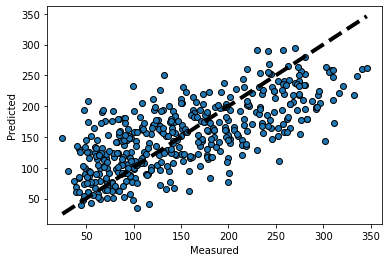

In [126]:
from sklearn import datasets
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
import matplotlib.pyplot as plt

lr = linear_model.LinearRegression()
X, y = datasets.load_diabetes(return_X_y=True)

# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
predicted = cross_val_predict(lr, X, y, cv=10)

fig, ax = plt.subplots()
ax.scatter(y, predicted, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()